In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import torch

In [3]:
os.chdir('/content/drive/My Drive/UPDVRP_MCD')

In [34]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import UPDVRP

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, line_width=1, visualize_demands=False, demand_scale=10, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1, including pickup and delivery demands.
    """
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    delivery_demands = data['delivery'].cpu().numpy()
    pickup_demands = data['pickup'].cpu().numpy()

    ax1.plot(depot[0], depot[1], 'sk', markersize=markersize*4)  # Depot location
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    qvs = []  # For storing quiver objects for legend
    total_dist = 0

    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        delivery_route_demands = delivery_demands[r - 1]
        pickup_route_demands = pickup_demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)  # Route nodes

        dist = np.linalg.norm(np.vstack([xs, ys]).T - np.roll(np.vstack([xs, ys]).T, 1, axis=0), axis=1).sum()
        total_dist += dist
        qv = ax1.quiver(xs[:-1], ys[:-1], xs[1:] - xs[:-1], ys[1:] - ys[:-1], scale_units='xy', angles='xy', scale=1, color=color)

        qvs.append(qv)

        ax1.plot([depot[0], xs[0]], [depot[1], ys[0]], color=color, linewidth=10)
        # Line from the last node to depot
        ax1.plot([xs[-1], depot[0]], [ys[-1], depot[1]], color=color, linewidth=10)


    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs, loc='upper center')

In [82]:
def plot_vehicle_routes(data, route, ax1, arrow_width=0.003, markersize=10, line_width=0.5, visualize_demands=False, demand_scale=10, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1, including pickup and delivery demands.
    """
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    delivery_demands = data['delivery'].cpu().numpy()
    pickup_demands = data['pickup'].cpu().numpy()

    ax1.plot(depot[0], depot[1], 'sk', markersize=markersize*2, mfc = 'green')  # Depot location
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    qvs = []  # For storing quiver objects for legend
    total_dist = 0

    for veh_number, r in enumerate(routes):
            color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order
            coords = locs[r - 1, :]
            xs, ys = coords.transpose()

            # Plot the route nodes
            ax1.plot(xs, ys, 'o', mfc='blue', markersize=markersize, markeredgewidth=0.0)

            # Draw arrows between nodes
            for j in range(len(xs) - 1):
                ax1.arrow(xs[j], ys[j], xs[j+1] - xs[j], ys[j+1] - ys[j], color='black', width=arrow_width)

            # Calculate and accumulate the distance
            dist = np.linalg.norm(np.vstack([xs, ys]).T - np.roll(np.vstack([xs, ys]).T, 1, axis=0), axis=1).sum()
            total_dist += dist

            # Arrow from the depot to the first node
            ax1.arrow(depot[0], depot[1], xs[0] - depot[0], ys[0] - depot[1], color='black', width=arrow_width)

            # Arrow from the last node to depot
            ax1.arrow(xs[-1], ys[-1], depot[0] - xs[-1], depot[1] - ys[-1], color='black', width=arrow_width)


    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))

In [63]:
model, _ = load_model('outputs/updvrp_10_2/epoch-99.pt')
torch.manual_seed(1234)
dataset = UPDVRP.make_dataset(foodbank = 10, num_products = 2, num_samples = 100)

  [*] Loading model from outputs/updvrp_10_2/epoch-99.pt


In [64]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True, beta = 10)
tours = pi

<ipython-input-44-0cd254cce069>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


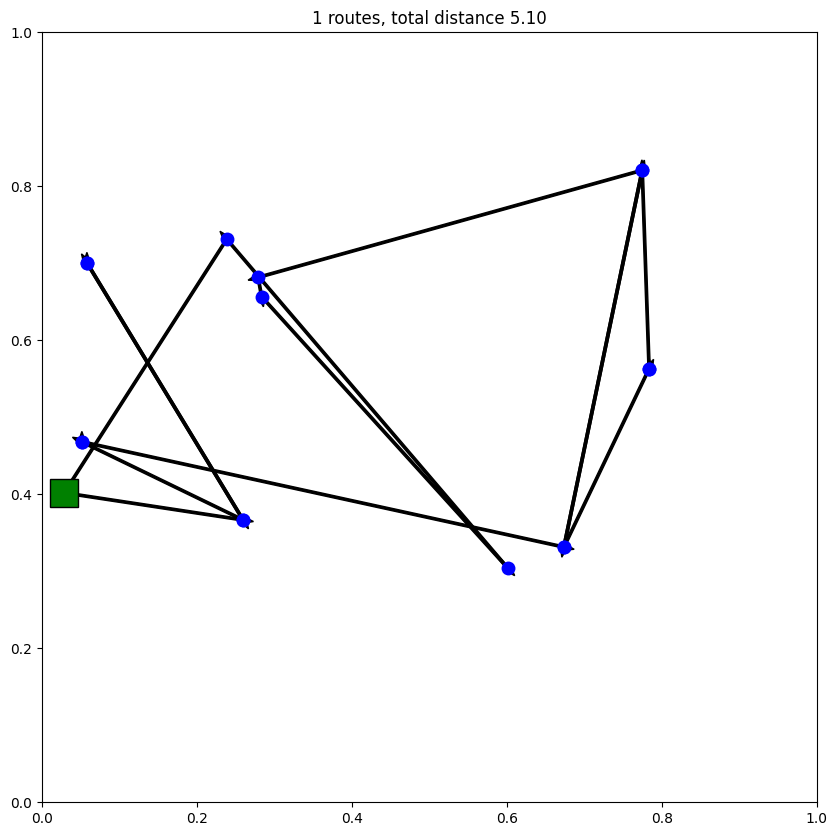

In [83]:
import os
import matplotlib.pyplot as plt

# Ensure the 'images' directory exists
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Plot the results
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)

    # Optionally save the figure
    fig.savefig(os.path.join(images_dir, f'cvrp_{i}.png'))

    # If you want to display the plot as well uncomment the following line
    #plt.show()
